# Research Engineer test task

Dear applicant!
We are asking you to implement a thoughtful pipeline for a rather simple toy task.

You are given the dataset from the Tiny ImageNet Challenge which is the default final project for Stanford [CS231N](http://cs231n.stanford.edu/) course. It runs similar to the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/2014/) (ILSVRC). The goal of the original challenge is for you to do as well as possible on the Image Classification problem.

Although your goal of this task is **not** just to do as good as possible on the Image Classification problem.
We would rather encourage you to demonstrate best practices and your skills of rapid prototyping reliable pipelines.
You may want to take a look at Andrej Karpathy's [Recipe for Training Neural Networks
](https://karpathy.github.io/2019/04/25/recipe/).

We provided you with a simple pytorch baseline. You are free to use it or to design the whole solution from scratch. 
We are not restricting you with the frameworks, you can install any package you need and organise your files however you want. Just please make sure to provide all the sources, checkpoints, logs, visualisations etc.
If you decide to use our platform setup, it is all already taken care of. We will just review the artifacts of your work on our storage. Otherwise it is your responsibility.

To add some measurable results to the task, your final goal will be to achieve best accuracy on the provided __test__ split of the Tiny ImageNet dataset.
Also you are expected to show all the visualisations you find necessary alongside with the final evaluation metrics. We already took care of a tensorboard setup for you, so you can track some of your plots there. Please follow  [README.md](https://github.com/neuromation/test-task/blob/master/README.md) for instructions. 

In [49]:
%%capture

from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, List, Optional, Sequence, Union

import pandas as pd
import torch
import os
from pandas import DataFrame
from PIL import Image
from torch.utils.data.dataloader import default_collate
from torch.utils.data.dataset import Dataset
import sklearn
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
from PIL import Image
from torchvision import transforms

from torchvision import models
from torch.nn.modules import loss
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from tqdm.auto import tqdm

# Getting the data

In [50]:
DATA_PATH = Path("/project/data")

In [ ]:
!! wget http://cs231n.stanford.edu/tiny-imagenet-200.zip -O $DATA_PATH/tiny-imagenet-200.zip

Unpacking our dataset will take a while, but it will only have to be done once.

Be prepared to wait next cell to finish up to 15 minutes

In [ ]:
!! [ ! -d $DATA_PATH/tiny-imagenet-200 ] && unzip $DATA_PATH/tiny-imagenet-200.zip -d $DATA_PATH

In [109]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64

# Dataset

Here is a `TinyImagenetDataset` warpper you might find useful.

In [51]:
Transform = Callable[[Image.Image], Image.Image]


@dataclass()
class ItemsBatch:
    images: torch.Tensor
    labels: torch.Tensor
    ids: List[int]
    paths: List[Path]
    items: List["DatasetItem"]


@dataclass()
class DatasetItem:
    image: Union[torch.Tensor, Image.Image]
    label: int
    id: int
    path: Path

    @classmethod
    def collate(cls, items: Sequence["DatasetItem"]) -> ItemsBatch:
        if not isinstance(items, list):
            items = list(items)
        return ItemsBatch(
            images=default_collate([item.image for item in items]),
            labels=default_collate([item.label for item in items]),
            ids=[item.id for item in items],
            paths=[item.path for item in items],
            items=items,
        )

In [53]:
DATA_ROOT = Path("/project/data/tiny-imagenet-200")
RESULTS_ROOT = Path("/project/results/")
CHECKPOINTS = RESULTS_ROOT / "checkpoints"
CHECKPOINTS.mkdir(parents=True, exist_ok=True)
TENSORBOARD_TAG = "second_try"
CKPT_NAME = "first_model.pth"
DEVICE = torch.device("cuda")

In [54]:
TRAIN_PATH = DATA_ROOT / "train"
VAL_PATH = DATA_ROOT / "val"
ALL_FOLDERS = [
    dir_name
    for r, d, f in os.walk(TRAIN_PATH)
    for dir_name in d
    if dir_name != "images"
]
FOLDERS_TO_NUM = {val: index for index, val in enumerate(ALL_FOLDERS)}

LABELS = pd.read_csv(
    DATA_ROOT / "words.txt", sep="\t", header=None, index_col=0)[1].to_dict()
VAL_LABELS = pd.read_csv(
    DATA_ROOT / "val" / "val_annotations.txt", sep="\t", header=None, index_col=0)[1].to_dict()

In [84]:
class TinyImagenetDataset(Dataset):
    _transform: Optional[Transform]
    _root: Path
    _df: DataFrame

    def __init__(self, path, transform: Optional[Transform] = None):
        self._transform = transform
        if not os.path.isdir(path):
            raise NotADirectoryError(f"{path} is not a directory.")
        all_files = [
            os.path.join(r, fyle)
            for r, d, f in os.walk(path)
            for fyle in f
            if ".JPEG" in fyle
        ]
        labels = [
            FOLDERS_TO_NUM.get(
                os.path.basename(f).split("_")[0],
                FOLDERS_TO_NUM.get(VAL_LABELS.get(os.path.basename(f))),
            )
            for f in all_files
        ]
        self._df = pd.DataFrame({"path": all_files, "label": labels})

    def __getitem__(self, index: int) -> DatasetItem:
        path, label = self._df.loc[index, :]
        image = Image.open(path).convert("RGB")
        if self._transform:
            image = self._transform(image)
        return DatasetItem(image=image, label=label, id=index, path=path)

    def __len__(self) -> int:
        return len(self._df)

ConcatDataset for merging multiple TinyImagenetDataset`s.

In [88]:
class ConcatDataset(TinyImagenetDataset):
    _datasets: tuple
    
    def __init__(self, *datasets):
        self._datasets = datasets

    def __getitem__(self, i):
        cur_i = i
        for d in self._datasets:
            if cur_i - len(d) >= 0:
                cur_i = cur_i - len(d)
            else:
                break
        return d[cur_i]

    def __len__(self):
        sum_len = 0
        return sum(len(d) for d in self._datasets)

# Training loop

The first idea is to perform data augmentation. Sometimes it can significally increase accuracy.

In [132]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

random_rotation_transform = transforms.Compose(
    [
        transforms.RandomRotation(20, expand=True),
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

color_jitter_transform = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

horizontal_flip_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

random_choice_transform = transforms.RandomChoice(
    [
        color_jitter_transform,
        horizontal_flip_transform,
    ]
)

In [133]:
train_dataset = TinyImagenetDataset(DATA_ROOT / "train", transform)
train_dataset_with_rotation = TinyImagenetDataset(DATA_ROOT / "train", random_rotation_transform)
train_dataset_flip_or_color = TinyImagenetDataset(DATA_ROOT / "train", random_choice_transform)
train_loader = torch.utils.data.DataLoader(
    ConcatDataset(
        train_dataset,
        train_dataset_with_rotation,
        train_dataset_flip_or_color
    ),
    batch_size=256,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=4,
)

test_dataset = TinyImagenetDataset(DATA_ROOT / "val" / "images", transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=4,
)

In [119]:
def train(model, device, train_loader, optimizer, loss_function, epoch, writer):
    model.train()
    model.to(device)
    correct = 0
    for batch_idx, batch_data in enumerate(tqdm(train_loader)):
        data, target = batch_data.images.to(device), batch_data.labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print(
        "Train Epoch: {} [ ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch, 100.0 * correct / len(train_loader.dataset), loss.item()
        )
    )
    writer.add_scalar("train_loss_plot", loss.item(), global_step=epoch)
    writer.add_scalar(
        "train_accuracy_plot",
        100.0 * correct / len(train_loader.dataset),
        global_step=epoch,
    )


def test(model, device, test_loader, loss_function, epoch, writer):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(test_loader)):
            data, target = batch_data.images.to(device), batch_data.labels.to(device)
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    writer.add_scalar("test_loss_plot", test_loss, global_step=epoch)
    writer.add_scalar(
        "test_accuracy_plot",
        100.0 * correct / len(test_loader.dataset),
        global_step=epoch,
    )

In [120]:
!! ls /project/results/checkpoints

['2019-09-17-20-37-41',
 '2019-09-17-21-03-15',
 '2019-09-17-23-01-38',
 '2019-09-17-23-01-54',
 '2019-09-17-23-02-51',
 '2019-09-17-23-04-16']

Method for loading saved model:

In [146]:
def load_model_to_cuda(path):
    device = torch.device("cuda")
    model = models.densenet201()
    model.fc = nn.Linear(512, 200)
    model.load_state_dict(torch.load(path, map_location="cuda"))
    model.to(device)
    
    return model

Using DenseNet-201 can help to increase efficienty of model by ~7%.

In [122]:
model = models.densenet201()
model.fc = nn.Linear(512, 200)
model = model.to(DEVICE)

loss_function = loss.CrossEntropyLoss()

In [123]:
from datetime import datetime
import pytz

local_tz = pytz.timezone('America/Los_Angeles')

def utc_to_local(utc_dt):
    local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(local_tz)
    return local_tz.normalize(local_dt)

def aslocaltimestr(utc_dt):
    return utc_to_local(utc_dt).strftime('%Y-%m-%d-%H-%M-%S')

Using simulated annealing algorithm сan make a big contribution to the process of finding a global minimum.

In [124]:
is_up = False
lr = 1

# lr vary from 0.00001 to 1
def simulated_annealing(lr):
    global is_up
    if lr == 1:
        is_up = False
    if lr == 0.00001:
        is_up = True
    
    if is_up is True:
        lr = lr * 10
    else:
        lr = lr / 10
    return lr

Then I make a couple of iterations, estimate current loss and accuracy and then decide if I need to do more iterations.

In [129]:
try:
    for epoch in range(20):
        writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)

        optimizer = optim.SGD(model.parameters(), lr=lr)
        lr = simulated_annealing(lr)

        train(model, DEVICE, train_loader, optimizer, loss_function, epoch, writer)
        test(model, DEVICE, test_loader, loss_function, epoch, writer)
        writer.close()
except Exception as e:
    print(e)
    time = aslocaltimestr(datetime.utcnow())
    torch.save(model.state_dict(), CHECKPOINTS / time)
    print("Model" + time + "saved")

Train Epoch: 0 [ (38%)]	Loss: 2.599978



Test set: Average loss: 0.0117, Accuracy: 3426/10000 (34%)



Train Epoch: 1 [ (38%)]	Loss: 2.668164



Test set: Average loss: 0.0119, Accuracy: 3421/10000 (34%)



Train Epoch: 2 [ (38%)]	Loss: 2.703285



Test set: Average loss: 0.0117, Accuracy: 3443/10000 (34%)



Train Epoch: 3 [ (39%)]	Loss: 2.311861



Test set: Average loss: 0.0116, Accuracy: 3442/10000 (34%)



Train Epoch: 4 [ (39%)]	Loss: 2.615419



Test set: Average loss: 0.0115, Accuracy: 3475/10000 (35%)



Train Epoch: 5 [ (41%)]	Loss: 2.577345



Test set: Average loss: 0.0115, Accuracy: 3528/10000 (35%)



Train Epoch: 6 [ (34%)]	Loss: 2.352217



Test set: Average loss: 0.0119, Accuracy: 3237/10000 (32%)



Train Epoch: 7 [ (57%)]	Loss: 1.606332



Test set: Average loss: 0.0100, Accuracy: 4159/10000 (42%)



Train Epoch: 8 [ (65%)]	Loss: 1.391924



Test set: Average loss: 0.0099, Accuracy: 4253/10000 (43%)



Train Epoch: 9 [ (66%)]	Loss: 1.618843



Test set: Average loss: 0.0098, Accuracy: 4240/10000 (42%)



Train Epoch: 10 [ (66%)]	Loss: 1.159367



Test set: Average loss: 0.0098, Accuracy: 4251/10000 (43%)



Train Epoch: 11 [ (66%)]	Loss: 1.525239



Test set: Average loss: 0.0099, Accuracy: 4245/10000 (42%)



Train Epoch: 12 [ (66%)]	Loss: 1.600828



Test set: Average loss: 0.0099, Accuracy: 4261/10000 (43%)



Train Epoch: 13 [ (66%)]	Loss: 1.338100



Test set: Average loss: 0.0098, Accuracy: 4232/10000 (42%)



Train Epoch: 14 [ (66%)]	Loss: 1.314635



Test set: Average loss: 0.0099, Accuracy: 4261/10000 (43%)



Train Epoch: 15 [ (68%)]	Loss: 1.276586



Test set: Average loss: 0.0104, Accuracy: 4151/10000 (42%)



Train Epoch: 16 [ (49%)]	Loss: 1.713579



Test set: Average loss: 0.0120, Accuracy: 3514/10000 (35%)



Train Epoch: 17 [ (76%)]	Loss: 0.866366



Test set: Average loss: 0.0100, Accuracy: 4372/10000 (44%)



Train Epoch: 18 [ (84%)]	Loss: 0.555840



Test set: Average loss: 0.0101, Accuracy: 4350/10000 (44%)



Train Epoch: 19 [ (85%)]	Loss: 0.665093



Test set: Average loss: 0.0101, Accuracy: 4353/10000 (44%)



In [130]:
try:
    for epoch in range(5):
        writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)

        optimizer = optim.SGD(model.parameters(), lr=lr)
        lr = simulated_annealing(lr)

        train(model, DEVICE, train_loader, optimizer, loss_function, epoch, writer)
        test(model, DEVICE, test_loader, loss_function, epoch, writer)
        writer.close()
    time = aslocaltimestr(datetime.utcnow())
    torch.save(model.state_dict(), CHECKPOINTS / time)
    print("Model" + time + "saved")
except Exception as e:
    print(e)
    time = aslocaltimestr(datetime.utcnow())
    torch.save(model.state_dict(), CHECKPOINTS / time)
    print("Model" + time + "saved")

Train Epoch: 0 [ (85%)]	Loss: 0.538229



Test set: Average loss: 0.0102, Accuracy: 4345/10000 (43%)



Train Epoch: 1 [ (85%)]	Loss: 0.618547



Test set: Average loss: 0.0101, Accuracy: 4332/10000 (43%)



Train Epoch: 2 [ (85%)]	Loss: 0.588108



Test set: Average loss: 0.0101, Accuracy: 4339/10000 (43%)



Train Epoch: 3 [ (85%)]	Loss: 0.652283



Test set: Average loss: 0.0102, Accuracy: 4347/10000 (43%)



Train Epoch: 4 [ (85%)]	Loss: 0.598153



Test set: Average loss: 0.0102, Accuracy: 4336/10000 (43%)

Model2019-09-18-11-01-45saved


In [131]:
try:
    for epoch in range(10):
        writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)

        optimizer = optim.SGD(model.parameters(), lr=lr)
        lr = simulated_annealing(lr)

        train(model, DEVICE, train_loader, optimizer, loss_function, epoch, writer)
        test(model, DEVICE, test_loader, loss_function, epoch, writer)
        writer.close()
    time = aslocaltimestr(datetime.utcnow())
    torch.save(model.state_dict(), CHECKPOINTS / time)
    print("Model" + time + "saved")
except Exception as e:
    print(e)
    time = aslocaltimestr(datetime.utcnow())
    torch.save(model.state_dict(), CHECKPOINTS / time)
    print("Model" + time + "saved")


Test set: Average loss: 0.0107, Accuracy: 4306/10000 (43%)



Train Epoch: 1 [ (63%)]	Loss: 1.089312



Test set: Average loss: 0.0122, Accuracy: 3780/10000 (38%)



Train Epoch: 2 [ (88%)]	Loss: 0.435736



Test set: Average loss: 0.0109, Accuracy: 4354/10000 (44%)



Train Epoch: 3 [ (92%)]	Loss: 0.348872



Test set: Average loss: 0.0109, Accuracy: 4369/10000 (44%)



Train Epoch: 4 [ (93%)]	Loss: 0.274296



Test set: Average loss: 0.0108, Accuracy: 4365/10000 (44%)



Train Epoch: 5 [ (93%)]	Loss: 0.308948



Test set: Average loss: 0.0109, Accuracy: 4369/10000 (44%)



Train Epoch: 6 [ (93%)]	Loss: 0.416202



Test set: Average loss: 0.0109, Accuracy: 4363/10000 (44%)



Train Epoch: 7 [ (93%)]	Loss: 0.357932



Test set: Average loss: 0.0108, Accuracy: 4352/10000 (44%)



Train Epoch: 8 [ (93%)]	Loss: 0.303233



Test set: Average loss: 0.0109, Accuracy: 4375/10000 (44%)



Train Epoch: 9 [ (93%)]	Loss: 0.398504



Test set: Average loss: 0.0109, Accuracy: 4375/10000 (44%)

Model2019-09-18-14-40-55saved


In [135]:
try:
    for epoch in range(10):
        writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)

        optimizer = optim.SGD(model.parameters(), lr=lr)
        lr = simulated_annealing(lr)
        print("lr=" + str(lr))

        train(model, DEVICE, train_loader, optimizer, loss_function, epoch, writer)
        test(model, DEVICE, test_loader, loss_function, epoch, writer)
        writer.close()
    time = aslocaltimestr(datetime.utcnow())
    torch.save(model.state_dict(), CHECKPOINTS / time)
    print("Model" + time + "saved")
except Exception as e:
    print(e)
    time = aslocaltimestr(datetime.utcnow())
    torch.save(model.state_dict(), CHECKPOINTS / time)
    print("Model" + time + "saved")

lr=0.1


Train Epoch: 0 [ (76%)]	Loss: 0.849326



Test set: Average loss: 0.0140, Accuracy: 3620/10000 (36%)

lr=0.01


Train Epoch: 1 [ (92%)]	Loss: 0.258008



Test set: Average loss: 0.0115, Accuracy: 4352/10000 (44%)

lr=0.001


Train Epoch: 2 [ (95%)]	Loss: 0.215525



Test set: Average loss: 0.0116, Accuracy: 4375/10000 (44%)

lr=0.0001


Train Epoch: 3 [ (95%)]	Loss: 0.186531



Test set: Average loss: 0.0117, Accuracy: 4365/10000 (44%)

lr=1e-05


Train Epoch: 4 [ (95%)]	Loss: 0.169786



Test set: Average loss: 0.0117, Accuracy: 4373/10000 (44%)

lr=0.0001


Train Epoch: 5 [ (95%)]	Loss: 0.276049



Test set: Average loss: 0.0115, Accuracy: 4379/10000 (44%)

lr=0.001


Train Epoch: 6 [ (95%)]	Loss: 0.168926



Test set: Average loss: 0.0117, Accuracy: 4363/10000 (44%)

lr=0.01


Train Epoch: 7 [ (95%)]	Loss: 0.200739



Test set: Average loss: 0.0116, Accuracy: 4369/10000 (44%)

lr=0.1


Train Epoch: 8 [ (95%)]	Loss: 0.197146



Test set: Average loss: 0.0116, Accuracy: 4379/10000 (44%)

lr=1.0


Train Epoch: 9 [ (96%)]	Loss: 0.259736



Test set: Average loss: 0.0118, Accuracy: 4294/10000 (43%)

Model2019-09-18-18-44-51saved


As we can see in the last cell, the model started overfitting. Let's load model from the previous cell.

In [147]:
loaded_model = load_model_to_cuda(CHECKPOINTS / "2019-09-18-14-40-55")

# Visualisation

Here is also a confusion matrix plot for you

In [148]:
import sklearn
import numpy as np
from matplotlib import pyplot as plt

In [149]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([200, 200], int)

with torch.no_grad():
    for item in tqdm(test_loader):
        images, labels = item.images.to(DEVICE), item.labels.to(DEVICE)
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1

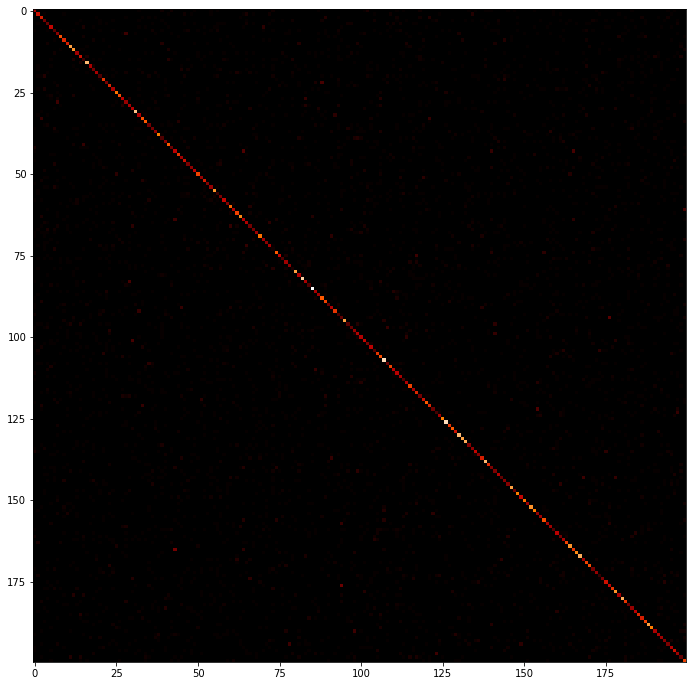

In [150]:
plt.figure(figsize=(12, 12))
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
plt.show()

We see a clear diagonal line - this means that most of elements of class i was classified as elements of class i.